<a href="https://colab.research.google.com/github/cybergis/twitter_example/blob/main/Trajectory_Preprocessing_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Trajectory Preprocessing Library Demo Notebook

#Summary and Credits
This notebook is designed to introduce the users to the Python Tweets Trajectory Preprocessing Library. This library is designed for the purpose of counting the number of travellers who are on Twitter, and calculating the relative change in visitors to each metropolitan area. 

This notebooks was created by Ben Liebersohn with code by Bin Su. This was also made possible by CyberGIS Center *Social Media and Viz Team* Leader Dr. Su Han, and fellow teammate Mike Qin, and CyberGIS Center Director Prof. Shaowen Wang. Additional thanks to CyberGIS Center teammate Becky Vanderwelle and to CyberGIS Center Coordinator Dr. Anand Padmanaman for their collective advice and support with Python computing and data storage. We also thank CyberGIS Center Fellow Dr. Ziqi Li and CyberGIS Center Member Alexander Michaels for advice.

Created at **The University of Illinois CyberGIS Center**. Created: 1/3/2021. Last updated: 3/7/2021.

#Introduction
The purpose of this notebook is to demonstrate functions for preprocessing Twitter data. The goal for this notebook is to detect changes in Twitter visits to a metropolitan area. Our idea is that an increased Covid-19 risk can be understood through an increase in visits. 

When accessing information from the Twitter API, many users share their spatial location. This notebook contains the functions which take these Tweets as input, and count the numer of visitors to each destination. Additionally, this notebook measures the change in visits, providing an indicator of increases in visits to a destination. When accumulating the visitors, the function "accu_dict" is able to accumulate the last n days in a moving window. 

Many of the functions in this notebook will be made into a library. 

We have a graphic below that helps explain what we mean by a moving window. After accumulating visitors, we measure the change in visitors to each location. 

In this data there is often zero new visitors, so to handle zero, we calculate the change in visitors by normalizing the change visitors relative relative to the global minimum and global maximum number of visitors in the data. This avoids the issue presented by small numbers having an outsized impact in the measurement in change counting travellers. This method is known as min-max scaling or feature scaling.

This notebook demonstrates these functions using synthetic data from GitHub. The synthetic data is based on Tweets captured by the Twitter API. The exact numbers were changed for validation purposes, but the format, including the origin and destination, is what the database looks like.

Upcoming additions: 

*   The functions will be packaged as a library.
*   There will be a standalone script, and a notebook, which call the library.
*   More parameters will be passed by the user, for example the size of the moving window.
*   More data will be available. (All of 2020!)
*   Exporting data to a shapefile will be functional in the JuPyteR environment for visualization.

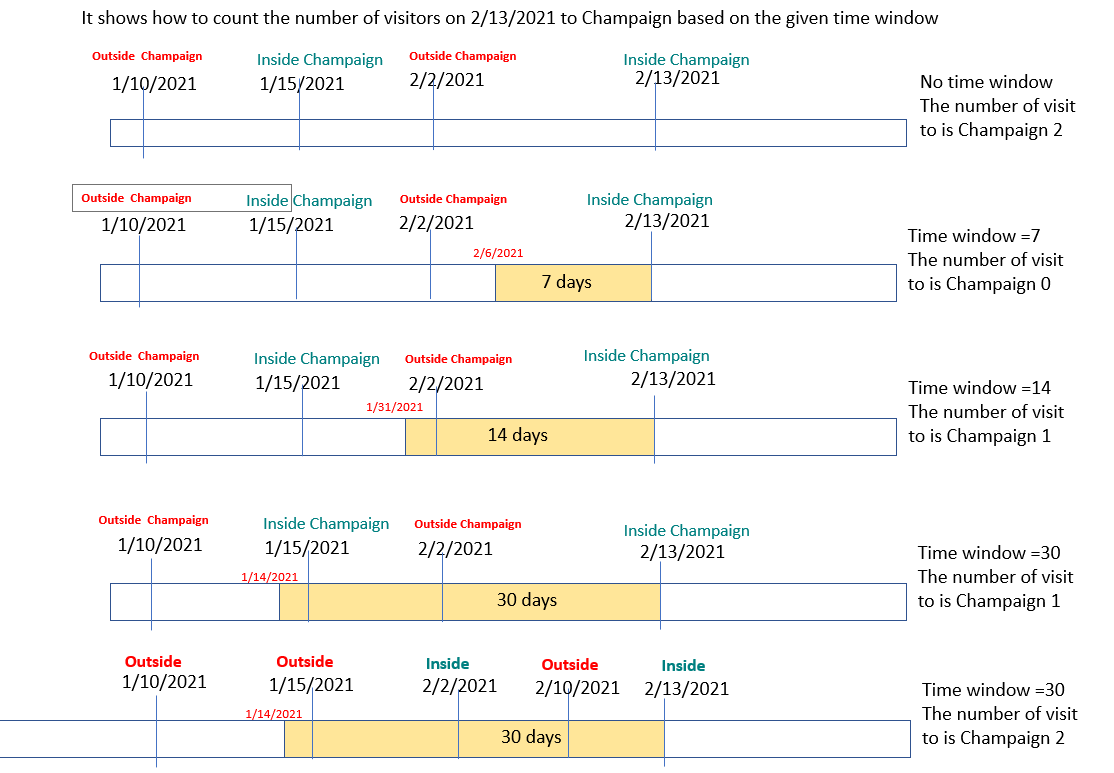
This graphic visualizes the moving window technique.

#Setup

To run these scripts, we will use the following files:

data that is used: world_region.zip

GeoID_name.csv

20_synthetic_days.csv

In [79]:
# Download the synthetic data
import pandas as pd
url = 'https://raw.githubusercontent.com/cybergis/twitter_example/main/20_days.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0]) 
df.to_csv("./20_days.csv")
# suggested method from Karl D and Ruthger Righart, https://stackoverflow.com/questions/23464138/downloading-and-accessing-data-from-github-python

In [80]:
#Download the name of each GeoID
import pandas as pd
url = 'https://raw.githubusercontent.com/cybergis/twitter_example/main/GeoID_name.csv'
df = pd.read_csv(url,encoding='latin1') # the Latin American accents make the format read in differently.
df.to_csv("./GeoID_name.csv")
# Latin1 allows us to use accents. Example: Española, New Mexico
# Suggested by Talha Rasool, https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c

#Functions/Main Code

In [81]:
# -*- coding: utf-8 -*-

"""
#### To access these Google Drive folders you must be a part of the CIGI-CyberGIS Google group.
In this code the data is pulled from Git. If it were to fail, however...
### GeoID_name.csv is kept in the following Google Drive directory:
### [CIGI-CyberGIS>Teams>CyberGIS-Viz-Socialmedia>20200720_code_mobility>COVID_data](https://drive.google.com/drive/folders/1xkdewCGw6iBhpJnVMCD3seN7rTzfGhJC?usp=sharing) 
### Download the Shapefile world_region.shp from the following Google Drive directory:
### [CIGI-CyberGIS>Teams>CyberGIS-Viz-Socialmedia>20200720_code_mobility>COVID_data>Shp](https://drive.google.com/drive/folders/1TpjEKivvjijW65gtcTnxJVb2gQC9Yo1V?usp=sharing)
"""
#This is not necessary for the demo. If you are a Drive user and you wish to use data hosted on Drive, you need to mount Drive. 
#from google.colab import drive
#drive.mount('/content/gdrive')

import numpy as np
import pandas as pd
from collections import defaultdict
import datetime as dt
import json
import sys
import os

def createat2date(str):
    """Convert a datetime in string format to date

    Args:
        str: the datetime to convert

    Returns:
        The date.

    """

    return str.split(' ')[0]

def data2chunks(read_path, write_folder):
    """

    Read the raw twitter streaming dataset, delete unnecessary columns.
    Then drop the rows in which author did not move from one place to
    another, and finally write chunks to disk.

    Args:
        read_path: the path of csv data
        write_folder: the destination folder.

    Returns:
        Nothing

    """
#i is the dataset
#index is the line
#
#chunk is a subset of the data
    chunksize = 10 ** 6
    print("\nStarting data2chunks, chunksize set to: ", chunksize)
    for i, chunk in enumerate(pd.read_csv(read_path, chunksize=chunksize)):
        df = chunk.loc[:, ['currentGEOID', 'lon', 'lat', 'name', 'author_Id', 'local_time', 'location', 'place_type', 'place_full_name', 'place_country']]
        # print(df.head())
        # break
        drop_idxs = []
        last_Id_place_date = ('', '')
        for index, row in df.iterrows():
            if row['place_type'] not in ['city', 'poi', 'neighborhood']:
                drop_idxs.append(index)
                continue
            row['local_time'] = createat2date(row['local_time'])
            if (row['author_Id'], row['currentGEOID']) == last_Id_place_date:
                drop_idxs.append(index)
            last_Id_place_date = (row['author_Id'], row['currentGEOID'])
        df = df.drop(drop_idxs)
        df.to_csv(write_folder + '/chunk_' + str(i) + '.csv', index=False)
        print("completed data2chunks, wrote data to this directory: ", write_folder)
        # break # when debugging you may want to break this loop for efficency 
#Chunks are a subset of the data stored in seperate files
#read_folder is the folder where the chunks are stored
#write_path is the folder where the pandas dictionary is stored
#start and end are inputs for the looping, and determined by the number of chunks
def chunks2dict(read_folder, write_path, start=0, end=1):
    """
    Read chunks from a fixed path. Then process index from start
    to end. The number of visitors will be accumulated in the nested
    map, which will finally be converted to a df and written down.
    Args:
        read_folder: from this folder we read chunks
        write_path: where to write the final result
        start: the index of start chunk
        end: the index of end chunk
    Returns:
        Nothing
    """

    m = defaultdict(lambda: defaultdict(int))
    last_id = ''
    print("\nStarting chunks2dict, processing chunks.")
    for i in range(start, end):
        print("Now processing chunk: ", i)
        df = pd.read_csv(read_folder + "/chunk_"+str(i)+".csv")
        for index, row in df.iterrows():
            if row['author_Id'] == last_id:
                place = row['currentGEOID']
                time = createat2date(row["local_time"])
                m[place][time] += 1
            last_id = row['author_Id']
    df = pd.DataFrame.from_dict(m, orient='index').sort_index(axis=1)
    df.reset_index(inplace=True)
    df = df.rename(columns={'index': 'GEOID'})
    df = df.fillna(0)
    df = pd.DataFrame(df, dtype='int64')
    df.insert(1, "geoName", "")
    df.insert(2, "geoRegion", "")
    df.insert(3, "geoLON", "")
    df.insert(4, "geoLAT", "")
    df.insert(5, "ISO3", "")
    df_query = pd.read_csv("./GeoID_name.csv", encoding="ISO-8859-1")
    for index, row in df.iterrows():
        # print("The row geoid is: ", int(row["GEOID"]))
        geoInfo = df_query[df_query["GEOID"] == int(row["GEOID"])]
        # print(geoInfo)
        df.at[index, "geoName"] = geoInfo["NAME"].values[0] if len(geoInfo["NAME"].values) > 0 else "NaN"
        df.at[index, "geoRegion"] = geoInfo["region"].values[0] if len(geoInfo["region"].values) > 0 else "NaN"
        df.at[index, "geoLON"] = geoInfo["LON"].values[0] if len(geoInfo["LON"].values) > 0 else "NaN"
        df.at[index, "geoLAT"] = geoInfo["LAT"].values[0] if len(geoInfo["LAT"].values) > 0 else "NaN"
        df.at[index, "ISO3"] = geoInfo["ISO3"].values[0] if len(geoInfo["ISO3"].values) > 0 else "NaN"
    df.to_csv(write_path)
    print("finished chunks2dict.")

def accu_dict(read_path, write_path, time_length):
    """

    This function accumulate any days visitors in each cell. For example,
    if the recent past 7 days number of visitors is [1,2,3,4,5,6,7], the cell
    will be 28.

    Args:
        read_path: the path from which we read our data
        write_path: the path we write our data to (notice, we will add time_length as suffix)
        time_length: The time length we want to accumulate

    Returns:
        Nothing
        A new dataframe whose each cell contains the number of past time_length
        days of visitors.

    """
    df = pd.read_csv(read_path) # this is the default dataframe which is not altered
    vs = pd.read_csv(read_path) # this is the visitors dataframe
    offset = 8
###############################################
    days = time_length                #days = total number of days to accumulate (time_length) or 
###############################################
    for k in range(0,15): # k is each window that is being accumulated
      #start = the first date column we consider accumulating
      #end   = the last  date column we consider accumulating
      start = offset+k # 7 is the offset of the first date column in the data
      end = 25 # 24 is the last column, we are using range

      for i in range(0,5): # i is the number of destination locations
          visitors_num = []
          for j in range (start,end): # j is the cursor, range(start, end) is the windows size
              visitors_num.append(int(df.iloc[:, j].at[i])) # read from df dataframe
              if len(visitors_num)==time_length:
                  special_accu = sum(visitors_num)          # this is the summation step
                  vs.iloc[:, j].at[i] = special_accu

              if len(visitors_num) > time_length:
                  visitors_num.pop(0)
              if k==0: #first window must be filled with 0
                  vs.iloc[:, j].at[i] = 0 # fill first window with zeroes!

    vs.to_csv(write_path)
    print("Finished accumulating and wrote output to ", write_path)


def max_min(read_path,start,end):
  
  df = pd.read_csv(read_path)
  
  globalmin = int(df.min()[start])
  globalmax = int(df.max()[start]) #initializing globalmax and globalmin

  for i in range(start,end):  #range is the columns with dates. Probably repeating start.
    if int(df.max()[i])>globalmax:
      globalmax=df.max()[i]
    elif int(df.min()[i])<globalmin:
      globalmin=df.min()[i]
    else:
      continue
#    print("DURING loop",i," globalmax:", globalmax,"globalmin: ", globalmin)
    #report max and min if you want
#  print("AFTER loop",i," globalmax:", globalmax,"globalmin: ", globalmin)
  maxMin = [globalmax,globalmin]
  return [maxMin]

def normal_change(read_path, write_path):
    """
Normalizing the change gives us a clear idea within the context of our data what is happening
The calc_percent function is very cool and has important mathematical properties but
This function is more understandable to a broader audience.
 Pseudocode:
 First day : zero

After the first day: YesterdayNormalization = TodayNormalization-1

 TodayVisitors - MinVisitors
-----------------------------   =   TodayNormalization
       MaxVisitors

result = (TodayNormalization - YesterdayNormalization) x 100

Days               [ 1,  2,     3,    4,    5,     6,     7,    8]
Visitors           [ 0,  5,     0,   10,    5,    15,    20,   40]
Normalization      [ 0,  0.125, 0,    0.25, 0.125, 0.375, 0.5,  1]
Diff               [ -, 12.5, -12.5, 25,  -12.5,  25,    12.5, 50]

    """

    df = pd.read_csv(read_path) #df is the dataframe we read in, and don't modify
    vs = pd.read_csv(read_path) #vs is the modified dataframe we write out

############################################################# Parameter
    destinations = 5 # number of rows, or destinations
#############################################################
#i is the row, or destination
#j is the column, or date

#start and end are the columns with days

    start = 8 #these should be passed not hardcoded 
    end = 24 # is it actually 24 or is it 25?
    globalmax=999 # initialize extreme numbers 
    globalmin=-999

    maxMin = max_min(read_path,start,end)
    globalmax = maxMin[0][0]
    globalmin = maxMin[0][1]

    for i in range(0,destinations): 
        for j in range(start, end): # skip the first day. it has no prior day to change from. 
            if j==start: #the first date is a special case, there is no preceding date
                     #if we assume the prior day has the same number of visitors, there is zero change
                vs.iloc[:, j].at[i] = 0 #enter zero on first day of change, update this to null
                continue                # and then we continue onward

            if j>start: #after the first date, a previous date exists, so we can use a previous column
                todayVisit = int(df.iloc[:, j].at[i])
                yesterVisit = int(df.iloc[:, j-1].at[i])
                
                todayNormalization = (todayVisit-globalmin)/globalmax
                yesterNormalization = (yesterVisit-globalmin)/globalmax
                normalChangeResult = todayNormalization-yesterNormalization
                
                vs.iloc[:,j].at[i] = normalChangeResult*100 # times 100 to get percentage?

            else:
                vs.iloc[:, j].at[i] = 999

    vs.to_csv(write_path)
  
"""

Helper function for converting string to datetime, string must be in the formate of "month-date-year", e.g. "2-14-2020"

"""


def str_to_date(input_string):
    input_string = input_string.split('/')

    for index in range(len(input_string)):
        input_string[index] = int(input_string[index])
 
    input_string = dt.datetime(input_string[2], input_string[0], input_string[1])

    return input_string

def convert_to_js(param):

    disease = param['InputCSV']
    beginDate = param['begin_date']
    endDate = param['end_date']

    beginDate = str_to_date(beginDate)
    endDate = str_to_date(endDate)

    df = pd.read_csv(disease)

    columns = list(df.columns)
    # print(columns)
    # return
    # columns.pop(0)
    # columns.pop(0)
  #  print(len(columns))
    for column in columns:
        if not '/' in column:
            continue
        column_date = str_to_date(column)
        if (column_date > endDate or column_date < beginDate):
            df = df.drop(column, 1)

    heading = list(df.columns)
    dirname = os.path.dirname("__file__") ### Added quotes to fix
    #dirname = os.path.basename(file)[:-3]
    filename = os.path.join(dirname, 'data')
    if not os.path.exists(filename):
        os.makedirs(filename)
    ofile = open('./content/dicts_folder/dict.js', 'w+')
    #ofile = open('./data/dict.js', 'w+')
    ofile.write('var GEO_VARIABLES =\n')
    ofile.write('[\n')
    ofile.write('  ' + json.dumps(heading) + ',\n')

    for index, row in df.iterrows():
        values = list(row)
        ofile.write('  ' + json.dumps(values) + ',\n')

    ofile.write(']\n')
    ofile.close()

def count_csv(input_csv,rows):

    df = pd.read_csv(input_csv)
    pd.set_option('display.max_columns', None) # max_columns none gets all columns
    #pd.reset_option(“max_columns”) #reset the number of columns to default
    columns = list(df.columns)
    
    print(df.head(rows))

def csv_columns(input_csv):

    df = pd.read_csv(input_csv)
    columns = list(df.columns)

#Runing the Scripts
##If you did not already, run the Setup section to download test data from public CyberGIS Git Repo twitter_example. 

##Preprocess data using data2chunks and chunks2dict
prepare our csv for processing by breaking a .csv file into chunks, and then convert each of these chunks into a dictionary.

These steps are important to make large datasets managable.

In [82]:
data2chunks("/content/20_days.csv", "/content/")
chunks2dict("/content/", "/content/dict_20_days.csv")


Starting data2chunks, chunksize set to:  1000000
completed data2chunks, wrote data to this directory:  /content/

Starting chunks2dict, processing chunks.
Now processing chunk:  0
finished chunks2dict.


##Using accu_dict to calculate 3, 7, and 11 day windows
Summarize the number of visitors in a moving time window, the size of the time window is defined by the user. Below are examples: three, seven eleven day time windows.

In [83]:
#Create three day time window accumulation
accu_dict("/content/dict_20_days.csv", "/content/accu_dict_20_3.csv", 3)
#Create seven day time window accumulation
accu_dict("/content/dict_20_days.csv", "/content/accu_dict_20_7.csv", 7)
#Create eleven day time window accumulation
accu_dict("/content/dict_20_days.csv", "/content/accu_dict_20_11.csv", 11)

Finished accumulating and wrote output to  /content/accu_dict_20_3.csv
Finished accumulating and wrote output to  /content/accu_dict_20_7.csv
Finished accumulating and wrote output to  /content/accu_dict_20_11.csv


##Calculate changes in visitors
This step is to get the normalized change in visitors to each location. In order to complete this, we will use the maximum and minimum number of visitors. This is to normalize our result when calculating change in visitors. We apply this to the no window, three, seven, and eleven day time windows.



1.   Compute normalization with min-max method.

2.   Subtract the normalized value for each day from the previous day.

In [84]:
# Calculate the normal change for one day, no time window
normal_change("/content/dict_20_days.csv","/content/normal_change_20.csv")

# Calculate the normal change for three day time window
normal_change ("/content/accu_dict_20_3.csv", "/content/accu_dict_3_days_change.csv")

# Calculate the normal change for seven day time window
normal_change ("/content/accu_dict_20_7.csv", "/content/accu_dict_7_days_change.csv")

# Calculate the normal change for eleven day time window
normal_change ("/content/accu_dict_20_11.csv", "/content/accu_dict_11_days_change.csv")

MIT Lisence

Copyright (c) 2021 Benjamin Liebersohn

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.